# Notebook 2 - Simulated annealing for the TSP

CSI4106 Artificial Intelligence  
Fall 2019  
Prepared by Caroline Barrière and Julian Templeton

***INTRODUCTION***:

This homework will allow you to look deeper into one of the randomized searches presented in class, that of *Simulated Annealing*. It is a good example of a *random modification* algorithm, in which we start with a greedy solution, and then make changes and accept the modified solutions with different probabilities given their level of fitness to a cost function.

The application domain for experimenting with *Simulated Annealing* is the traveling salesman problem (TSP), which is a classical problem of scheduling, with optimization on the cost of travel.

The notebook will lead into the **Simulated Annealing** portion after exploring a **greedy approach** and a **randomized greedy approach**.

***HOMEWORK***:  
Go through the notebook by running each cell, one at a time.  
Look for **(TO DO)** for the tasks that you need to perform. Do not edit the code outside of the questions which you are asked to answer unless specifically asked. Once you're done, sign the notebook (see the added step at the end), and submit it.  

*The notebook will be marked on 20.  
Each **(TO DO)** has a number of points associated with it.*
***

**1. Let's start with a small set of cities.**

In [1]:
# let's define 5 cities with a label and a (x,y) coordinate
cities = {'A': (0,0), 'B': (1,1), 'C': (0,1), 'D': (-1,1), 'E': (-1,-1)}

Let's plot the nodes using the *showNodes* method below.  
The packages matplotlib, networkx, and numpy must be installed first.  
To do so, open a command prompt and type **pip install numpy**, **pip install matplotlib**, and also **pip install networkx** (If you are using linux or potentially Mac, you may need to use **pip3** rather than **pip** depending on how you set it up).  After installing the packages, run the cell below. If it does not work, restart the Kernel and run through it again to be able to run the cell.

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# small method to show nodes
# provide defaults for figure size (size), as well as x and y axis
def showNodes(nodeDict, size= (6.5, 4), xLim=[-2,2], yLim=[-2,2]):
    fig = plt.figure(figsize=size)
    axg = fig.add_subplot(111)
    axg.set_xlim(xLim)
    axg.set_ylim(yLim)

    G=nx.Graph()
    for k in nodeDict.keys():
        G.add_node(k, coor=nodeDict.get(k))
    
    pos=nx.get_node_attributes(G,'coor')
    nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.show()

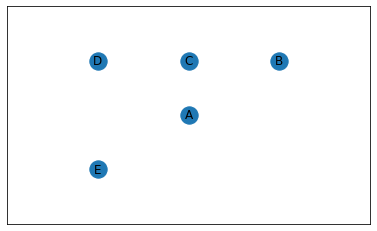

In [3]:
# show the cities on a map
showNodes(cities)

#### 2. Let's find the distances between all cities.
First, we define a method to calculate the distance between two specific cities, and then a method to find the distances between all pairs of nodes.

In [4]:
import math

# returns the euclidian distance between two nodes
def dist(node1, node2):
    return round(math.sqrt(math.pow(node1[0] - node2[0], 2) + math.pow(node1[1] - node2[1], 2)), 3)

In [5]:
# Small test to see the distance
dist(cities.get('A'), cities.get('B'))

1.414

In [6]:
# building a dictionary of all pairs or distances
def distDict(nodes):
    distance = {}
    # go through all pairs of nodes
    for k in nodes.keys():
        for m in nodes.keys():
            distance[k,m] = dist(nodes.get(k), nodes.get(m))
    return distance

In [7]:
# showing the distances between the cities
distances = distDict(cities)
print(distances)

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 1.0, ('C', 'E'): 2.236, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 1.0, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0}


In [8]:
# find the min distance from node1 to all other nodes.
# it receives the node1 label, the labels of other nodes to test,
# and the precalculated distances between all nodes
def closestNode(node1_label, otherNodes_Labels, distanceDict):
    # tricky syntax... it creates tuples where the distance is the first element of the tuple
    # and the position in the array is the second element of the tuple
    minDist = min( (distanceDict[node1_label,k], k) for k in otherNodes_Labels)
    # get the second element of the tuple which is the index found
    foundNode = minDist[1]
    return foundNode

In [9]:
# Testing the closest node
closestNode('B', ['C', 'D'], distances)

'C'

#### 3. Greedy solution first 
Before we can apply *simulated annealing*, we must first find a suboptimal solution that we will refine. The first solution will be a Greedy solution. Only the choice of the starting node is random in this solution, and from there, the algorithm always choses the closest node.

In [10]:
# greedy solution
import random

def greedy_solution(nodes):
    # distance matrix
    allDist = distDict(nodes)
    # pick a first node at random among the set of keys (node names)
    cur_node = random.choice(list(nodes.keys()))
    # add that node to solution
    solution = [cur_node]
    # build a free list of nodes (not yet used) containing all nodes except the one just chosen 
    free_list = list(nodes.keys())
    free_list.remove(cur_node)
    
    # while there are still nodes to be attached
    while free_list:
        # find the closestNode
        found_node = closestNode(cur_node, free_list, allDist)
        cur_node = found_node
        free_list.remove(cur_node)
        solution.append(cur_node)

    return solution

In [11]:
# Test obtaining a greedy solution
gs = greedy_solution(cities)
print(gs)

['E', 'A', 'C', 'B', 'D']


#### 4. Showing a path.  
We slightly modify to showNodes method from before, to become showPath, wich is now a directed graph.

In [12]:
# small method to show a path
# it receives an ordered list of nodes e.g. ['B','C','A', 'D', 'E']
# and a dictionary of all the nodes and their positions
def showPath(path, nodeDict, size= (6.5, 4), xLim=[-2,2], yLim=[-2,2]):
    fig = plt.figure(figsize=size)
    axg = fig.add_subplot(111)
    axg.set_xlim(xLim)
    axg.set_ylim(yLim)

    G=nx.DiGraph()
    for k in path:
        G.add_node(k, pos=nodeDict.get(k))
        
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i + 1]
        G.add_edge(x,y)
        
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, with_labels = True, edge_color = 'b', arrows=True)   
    # nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.show()

**(TO DO) Q1 - 2 marks**  
1. Select a seed (integer) to use in the cell below
2. Run that cell to set the seed (only once)
3. Run the tests below the seed declaration repeatedly (just manually run it) until you get two identical results in the same run. Record how many runs it took and the solution found in the answer section below.
4. Run the tests below the seed declaration repeatedly (just manually run it) until you get two different results in the same run. Record how many runs it took and the solution found in the answer section below.

**(ANSWER in this Markdown) Q1**  
Nb of runs needed to generate an identical gs1 and gs2 : 13  
Solution generated for the identical gs1 and gs2 : ['B', 'C', 'A', 'D', 'E']

Nb of runs needed to generate a different gs1 and gs2 :  1
Solutions generated for the distinct gs1 and gs2 : ['B', 'C', 'A', 'D', 'E'] & ['C', 'A', 'B', 'D', 'E']

Setup the seed:

In [13]:
# To Do: Place your seed here and run the cell to set/reset it
# random.seed(int)
random.seed(10)

Let us run a test to visualize two greedy solutions

['E', 'A', 'C', 'B', 'D']


c:\users\kenny.kensurf\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\users\kenny.kensurf\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


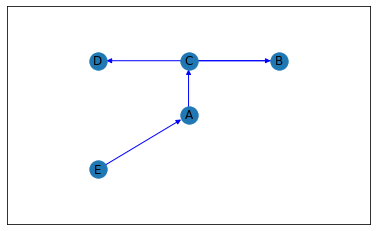

['A', 'C', 'B', 'D', 'E']


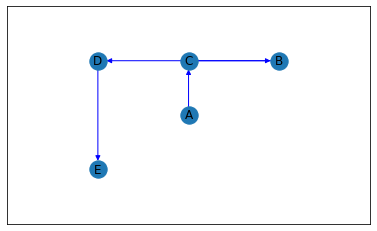

In [14]:
# To Do: Need to run this (make no changes) and answer the questions above

# Testing to output the path chosen by the greedy solution
gs1 = greedy_solution(cities)
print(gs1)
showPath(gs1, cities)
gs2 = greedy_solution(cities)
print(gs2)
showPath(gs2, cities)

**(TO DO) Q2 - 2 marks**  
Complete the method to find the total length of the path found.  

In [15]:
# (TO DO) totalDistance, which receives a path (list of node labels) and the dictionary of distances
def totalDist(path, distanceDict):
    total = 0
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i+1]
        total += distances.get((x,y),total)
    return round(total,3)

In [16]:
# Test the total distance method
print(totalDist(gs1, distances))
print(totalDist(gs2, distances))

5.414
6.0


**(TO DO) Q3 - 4 marks**  
Add two more cities (wherever you want within the predefined -2 to +2 axis).  Rerun the full sequence of tasks performed above on the larger set of cities that you will define below: (1) defining the graph (2) showing the points (3) building the distance dictionary, (4) finding two unique greedy solutions, (5) showing the different paths found along with their total distances.

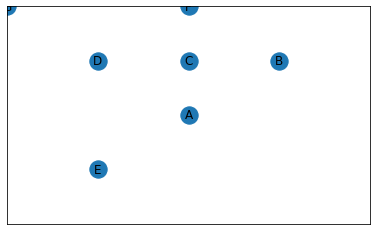

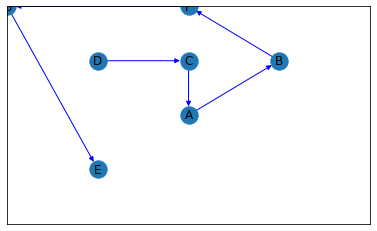

['D', 'C', 'A', 'B', 'F', 'G', 'E']
27.312


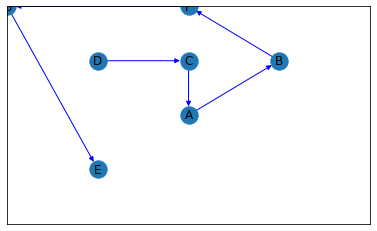

['D', 'C', 'A', 'B', 'F', 'G', 'E']
27.312


In [17]:
# (1) Defining a larger set of cities  (add two more)
moreCities = {'A': (0,0), 'B': (1,1), 'C': (0,1), 'D': (-1,1), 'E': (-1,-1), 'F': (0,2), 'G': (-2,2)}
# (2) Show the points
showNodes(moreCities)
# (3) Build the distance dictionary
moreDistances = distDict(moreCities)
# (4) Find two unique greedy solutions 
moregs1 = greedy_solution(moreCities)
moregs2 = greedy_solution(moreCities)
# (5) Show the two unique paths found above along with their total distances
showPath(moregs1, moreCities)
print(moregs1)
print(totalDist(moregs1, moreDistances))

showPath(moregs2, moreCities)
print(moregs2)
print(totalDist(moregs2, moreDistances))

**5. Randomized Greedy - Setup**

Before we create our Randomized Greedy solution, we will define a new function called kClosestNodes that will return the k-closest nodes to a given node.

In [18]:
# find the min distance from node1 to all other nodes.
# it receives the node1 label, the labels of other nodes to test,
# the precalculated distances between all nodes, and k for how many to return
# The function then outputs a list of the k-closest nodes, where the
# first is the closest and the kth is the kth-closest
def kClosestNodes(node1_label, otherNodes_Labels, distanceDict, k):
    kClosest = []
    # Create a sorted distance list based on the values from the distance dictionary
    # This has the form [((node_1, node_2),value_1), ..., ((node_n, node_n), value_n)]
    sortedDistances = sorted(distanceDict.items(), key=lambda keyPair: keyPair[1])
    # Iterate through the sorted distance list to find our k min distances
    # from node1_label
    for key, value in sortedDistances:
        if (k > 0 and key[0] == node1_label and key[1] in otherNodes_Labels):
            k -= 1
            kClosest.append(key[1])
    return kClosest

In [19]:
# Example usage
# View the distance dictionary to verify correctness when finding the closest nodes
# to node B in cities
print(distances)
# Find the two closest nodes to the node B in cities (using its distance dictionary)
kClosestNodes('B', ['A', 'C', 'D', 'E'], distances, 2)

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 1.0, ('C', 'E'): 2.236, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 1.0, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0}


['C', 'A']

**6. Randomized Greedy**

Next you will find another suboptimal solution that we will refine. This second solution will be a Randomized Greedy solution.

**(TO DO) Q4 - 5 marks**  
The Randomized Greedy solution that you will create still selects a random first node, but should now pick randomly among the k closest nodes available given a probability distribution (rather than the closest node).

For example, if you found the five closest nodes when looking for which to add next, you would randomly choose one of them where the closest nodes would have a higher probability of being chosen then the nodes that are not as close.

The probability distribution for a set of node distances is given by the function *normalize* below and finding the k-closest nodes is given from the kClosestNodes function above. You must call both of these functions in your solution and follow the general structure defined by the comments.

After finishing the function, add one more test to the tests below with a different value for k

In [20]:
import random
import numpy as np

# DO NOT EDIT THIS FUNCTION
# nodeFrom is the node we start at, nodesTo is a list of nodes
# that nodeFrom can go to, and distDict is the dictionary of all
# combinations of distances.
# This provides the probability distribution to be used by
# randomized_greedy_solution
def normalize(nodeFrom, nodesTo, distDict):
    distances = []
    # Here we normalize by 1/distance^2 
    for nodeTo in nodesTo:
        distances.append(1 / distDict[nodeFrom, nodeTo] ** 2)
    sumOfDistances = sum(distances)
    normalizedDistances = [dist / sumOfDistances for dist in distances]
    return normalizedDistances
    
# k represents the number of closest nodes to be returned from the
# function kClosestNodes
def randomized_greedy_solution(nodes, k):
    # distance matrix
    allDist = distDict(nodes)
    # pick a first node at random among the set of keys (node names)
    cur_node = random.choice(list(nodes.keys()))
    # add that node to solution
    solution = [cur_node]
    # build a free list of nodes (not yet used) containing all nodes except the one just chosen 
    free_list = list(nodes.keys())
    free_list.remove(cur_node)
    
    # while there are still nodes to be attached
    while free_list:
        
        # TO DO START: Complete the algorithm by performing what the comments ask
        
        # Get the closest nodes
        cur_node=str(cur_node)
        nodeClosest = kClosestNodes(cur_node, free_list, allDist, k)
        # Find the normalized distances
        distNormalized = normalize(cur_node, nodeClosest, allDist)
        # Select a random closest node based on the probabilities found by the normalized distances
        # You will use the function np.random.choice(options, list_of_probabilities_for_options)
        # For more information on np.random.choice check out the official documentation:
        #      https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html#numpy.random.choice
        nodeClosestRandom = np.random.choice(nodeClosest, 1, replace=False, p=distNormalized)
        # Print out the probabilities for each closest node choice (just output both lists saying what they are)
        print("Closest node is: ", nodeClosest)
        # Print out the closest node selected by the probability distribution with it's probability of being selected
        print("Closest node selected by distribution probability is: ", nodeClosestRandom[0], ", with a probability of: ", distNormalized[nodeClosest.index(nodeClosestRandom[0])])
        found_node = nodeClosestRandom[0]
        # TO DO END
        
        # Same as in the Greedy approach
        cur_node = found_node
        free_list.remove(cur_node)
        solution.append(cur_node)

    return solution

Greedy Test
['E', 'A', 'C', 'B', 'F', 'D', 'G']
27.312


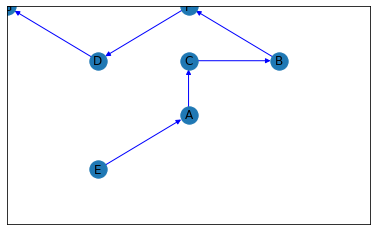

Randomized Greedy Test
Closest node is:  ['C']
Closest node selected by distribution probability is:  C , with a probability of:  1.0
Closest node is:  ['B']
Closest node selected by distribution probability is:  B , with a probability of:  1.0
Closest node is:  ['F']
Closest node selected by distribution probability is:  F , with a probability of:  1.0
Closest node is:  ['D']
Closest node selected by distribution probability is:  D , with a probability of:  1.0
Closest node is:  ['G']
Closest node selected by distribution probability is:  G , with a probability of:  1.0
Closest node is:  ['E']
Closest node selected by distribution probability is:  E , with a probability of:  1.0
['A', 'C', 'B', 'F', 'D', 'G', 'E']
32.0


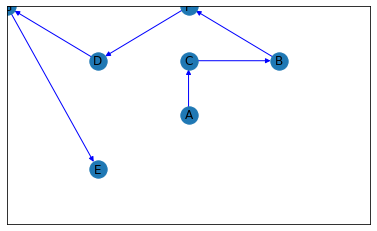

Randomized Greedy Test
Closest node is:  ['C', 'A']
Closest node selected by distribution probability is:  A , with a probability of:  0.3334004579588691
Closest node is:  ['C', 'D']
Closest node selected by distribution probability is:  D , with a probability of:  0.3334004579588691
Closest node is:  ['C', 'F']
Closest node selected by distribution probability is:  C , with a probability of:  0.6665995420411309
Closest node is:  ['F', 'E']
Closest node selected by distribution probability is:  F , with a probability of:  0.8333248884610154
Closest node is:  ['G', 'E']
Closest node selected by distribution probability is:  G , with a probability of:  0.7142498730555061
Closest node is:  ['E']
Closest node selected by distribution probability is:  E , with a probability of:  1.0
['B', 'A', 'D', 'C', 'F', 'G', 'E']
30.624


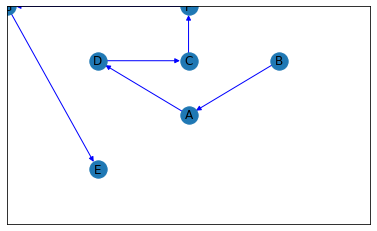

Closest node is:  ['C', 'A', 'F']
Closest node selected by distribution probability is:  A , with a probability of:  0.25003775570111086
Closest node is:  ['C', 'B', 'E']
Closest node selected by distribution probability is:  B , with a probability of:  0.25003775570111086
Closest node is:  ['C', 'F', 'E']
Closest node selected by distribution probability is:  F , with a probability of:  0.3077495017535567
Closest node is:  ['C', 'G', 'E']
Closest node selected by distribution probability is:  C , with a probability of:  0.7407311040572893
Closest node is:  ['E', 'G']
Closest node selected by distribution probability is:  E , with a probability of:  0.5
Closest node is:  ['G']
Closest node selected by distribution probability is:  G , with a probability of:  1.0
['D', 'A', 'B', 'F', 'C', 'E', 'G']
27.096


In [21]:
# Testing to output the path chosen by the randomized greedy solution with various k's to the greedy solution
# Run a few times to see how the results differ with the non-deterministic Randomized Greedy solution
# Note that if they start with the same node and k=1 that the results of both will be the same
print("Greedy Test")
gr = greedy_solution(moreCities)
print(gr)
print(totalDist(gr, moreDistances))
showPath(gr, moreCities)
print("Randomized Greedy Test")
rgs1 = randomized_greedy_solution(moreCities, 1)
print(rgs1)
print(totalDist(rgs1, moreDistances))
showPath(rgs1, moreCities)
print("Randomized Greedy Test")
rgs2 = randomized_greedy_solution(moreCities, 2)
print(rgs2)
print(totalDist(rgs2, moreDistances))
showPath(rgs2, moreCities)
# TO DO: Add one more test randomized_greedy_solution with a different k
rgs3 = randomized_greedy_solution(moreCities, 3)
print (rgs3)
print(totalDist(rgs3, moreDistances))

**7. Defining the process of simulated annealing**  
The class below defines the simulated annealing process.  This class is an adaptation of the class anneal.py found in the python code provided in this github https://github.com/chncyhn/simulated-annealing-tsp. You are not asked to changed this class, just go through it and try to understand it so as to get a better understanding of the *simulated annealing* algorithm.

In [22]:
# class to perform a simulated annealing
# must start with a set of nodes, all other parameters have defaults
class SimAnneal(object):
    def __init__(self, nodes, randomizedGreedy, k=4, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        # set of nodes
        self.nodes = nodes
        # number of nodes
        self.N = len(nodes)
        # set the temperature T to sqrt(N) if not specified
        self.T = math.sqrt(self.N) if T == -1 else T
        # set alpha (rate at which the temperature is decreased)
        self.alpha = 0.995 if alpha == -1 else alpha
        # set stopping temprature
        self.stopping_temperature = 0.00000001 if stopping_T == -1 else stopping_T
        # set stopping iteration
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        # start at iteration 1
        self.iteration = 1

        # calculate the distances
        self.allDist = distDict(nodes)
        
        # start with greedy solution if randomizedGreedy is false,
        #  start with the randomized greedy solution if randomizedGreedy is true
        if (randomizedGreedy):
            self.cur_solution = randomized_greedy_solution(nodes, k)
            self.improvementMessage = 'Improvement over randomized greedy heuristic: '
        else:
            self.cur_solution = greedy_solution(nodes)
            self.improvementMessage = 'Improvement over greedy heuristic: '
        
        # so far, the best solution is the one we have
        self.best_solution = list(self.cur_solution)

        # calculate fitness of the current solution
        self.cur_fitness = self.fitness(self.cur_solution)
        # initial fitness for initial solution
        self.initial_fitness = self.cur_fitness
        # best fitness so far
        self.best_fitness = self.cur_fitness
        # build the fitness list as we explore solutions
        self.fitness_list = [self.cur_fitness]


    def fitness(self, sol):
        """ Objective value of a solution """
        return totalDist(sol, self.allDist)

    # acceptance propability
    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current
        Depends on the current temperature and difference between candidate and current
        """
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current
        Accept with probabilty p_accept(..) if candidate is worse
        """
        candidate_fitness = self.fitness(candidate)
        # test if fitness is smaller then the current one
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.cur_solution = candidate
            # test if fitness is better than best so far, keep it as best if so
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.best_solution = candidate

        # if solution is worst than the current one, there is still a possibility to pursue it
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness = candidate_fitness
                self.cur_solution = candidate

    def anneal(self):
        """
        Execute simulated annealing algorithm
        """
        # go through the temperature schedule
        print(self.T)
        print(self.stopping_temperature)
        while (self.T >= self.stopping_temperature) and (self.iteration < self.stopping_iter):
            # explore current solution
            candidate = list(self.cur_solution)
            # modify the solution to switch two cities
            # first chosen city between [2,N-1] - not changing the first city
            l = random.randint(2, self.N - 1)
            # second city between [0,N-1] Not sure why ??
            i = random.randint(0, self.N - l)
            # the chosen nodes are switch
            candidate[i:(i + l)] = reversed(candidate[i:(i + l)])
            # perform acceptance test 
            self.accept(candidate)
            # multiply the temperature by alpha (this will reduce it)
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list (to be able to display)
            self.fitness_list.append(self.cur_fitness)

        print('Best fitness obtained: ', self.best_fitness)
        print(self.improvementMessage,
              round((self.initial_fitness - self.best_fitness) / (self.initial_fitness), 4))

        return self.best_solution
    
    def plot_learning(self):
        """
        Plot the fitness through iterations
        """
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel('Fitness')
        plt.xlabel('Iteration')
        plt.show()


#### 8. Refining a greedy solution through simulated annealing.

**(TO DO) Q5 - 5 marks**  
Put comments in the code below explaining what it does.  Also run it a few times.  It will show you how there can be improvement (or not) from the greedy solution and randomized greedy solution to the annealed one.

Solution ['G', 'D', 'C', 'A', 'B', 'F', 'E'] takes a total of 9.404


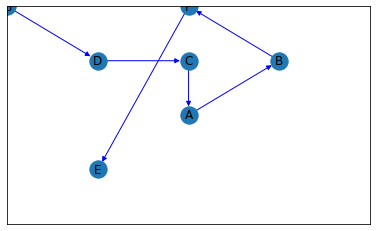

2.6457513110645907
1e-08
Best fitness obtained:  7.656
Improvement over greedy heuristic:  0.2336


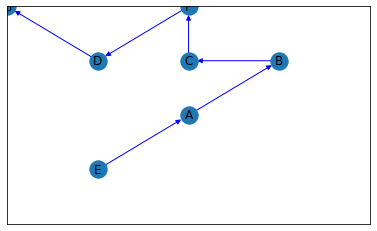

Closest node is:  ['C', 'A', 'F', 'G']
Closest node selected by distribution probability is:  A , with a probability of:  0.2000241629188806
Closest node is:  ['C', 'B', 'E', 'F']
Closest node selected by distribution probability is:  C , with a probability of:  0.44438478011310784
Closest node is:  ['B', 'F', 'E', 'G']
Closest node selected by distribution probability is:  B , with a probability of:  0.4166624442305077
Closest node is:  ['F', 'E', 'G']
Closest node selected by distribution probability is:  F , with a probability of:  0.6896671985164585
Closest node is:  ['G', 'E']
Closest node selected by distribution probability is:  G , with a probability of:  0.7142498730555061
Closest node is:  ['E']
Closest node selected by distribution probability is:  E , with a probability of:  1.0
Solution ['D', 'A', 'C', 'B', 'F', 'G', 'E'] takes a total of 9.99


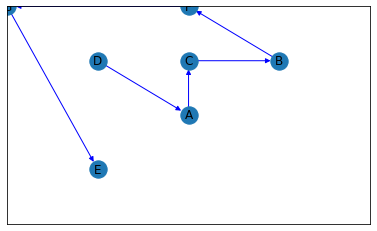

Closest node is:  ['D', 'F', 'C', 'A']
Closest node selected by distribution probability is:  D , with a probability of:  0.46516982463118345
Closest node is:  ['C', 'A', 'F', 'B']
Closest node selected by distribution probability is:  A , with a probability of:  0.2222595124293076
Closest node is:  ['C', 'B', 'E', 'F']
Closest node selected by distribution probability is:  E , with a probability of:  0.2222595124293076
Closest node is:  ['C', 'B', 'F']
Closest node selected by distribution probability is:  C , with a probability of:  0.47054213199199235
Closest node is:  ['B', 'F']
Closest node selected by distribution probability is:  F , with a probability of:  0.5
Closest node is:  ['B']
Closest node selected by distribution probability is:  B , with a probability of:  1.0
2.6457513110645907
1e-08
Best fitness obtained:  7.656
Improvement over randomized greedy heuristic:  0.139


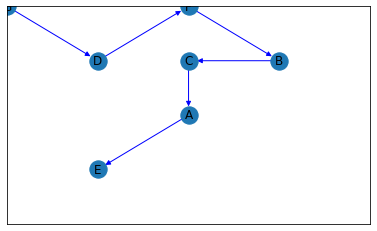

In [23]:
firstSol = greedy_solution(moreCities)
# This solution uses the greedy search function from above.

distances = distDict(moreCities)
# Builds a dictionary of all pairs or distances of moreCities.

print('Solution {} takes a total of {}'.format(firstSol,totalDist(firstSol, distances)))
# Prints the total distance of the path

showPath(firstSol, moreCities)
# Prints the path

sa = SimAnneal(moreCities, False)
# Performs a simulated annealing, starting with greedy solution because randomizedGreedy = False.

betterSol = sa.anneal()
# Updates greedy search solution depending on best fitness.

showPath(betterSol, moreCities)
# Prints new path

secondSol = randomized_greedy_solution(moreCities, 4)
# This solution uses randomized greedy solution, choosing the 4 closest nodes.

print('Solution {} takes a total of {}'.format(secondSol,totalDist(secondSol, distances)))
# Prints out the total distance.

showPath(secondSol, moreCities)
# Prints out the path.

sa2 = SimAnneal(moreCities, True, 4)
# Performs a simulated annealing, starting randomized greedy solution, choosing the 4 closest nodes.

betterSol2 = sa2.anneal()
# Updates randomized greedy search solution depending on best fitness.

showPath(betterSol2, moreCities)
# Prints new path


**9. Moving toward a larger example**  
There are a set of coordinates defined in the file *coord.txt* (available in the Jupyter Notebooks module in Brightspace). This data file is also from the github https://github.com/chncyhn/simulated-annealing-tsp.  It contains a larger example with 45 cities, to test.  Here is the beginning of the file:

1 0 0  
2 3 5  
3 2.5 9  
4 48 16  
5 48 17  
6 69 16  
...

Make sure to put the file *coord.txt* in the same repertory as your notebook or modify the path below when opening the file to read.  We will assume the first number is the label, and the other two numbers are the coordinates.

In [24]:
# reading the coordinates
manyCities = {}
with open('coord.txt','r') as f:
    i = 0
    for line in f.readlines():
        line = [float(x.replace('\n','')) for x in line.split(' ')]
        label = str(int(line[0]))
        manyCities[label] = (line[1], line[2])
        i += 1

Show the nodes from that larger set of cities.

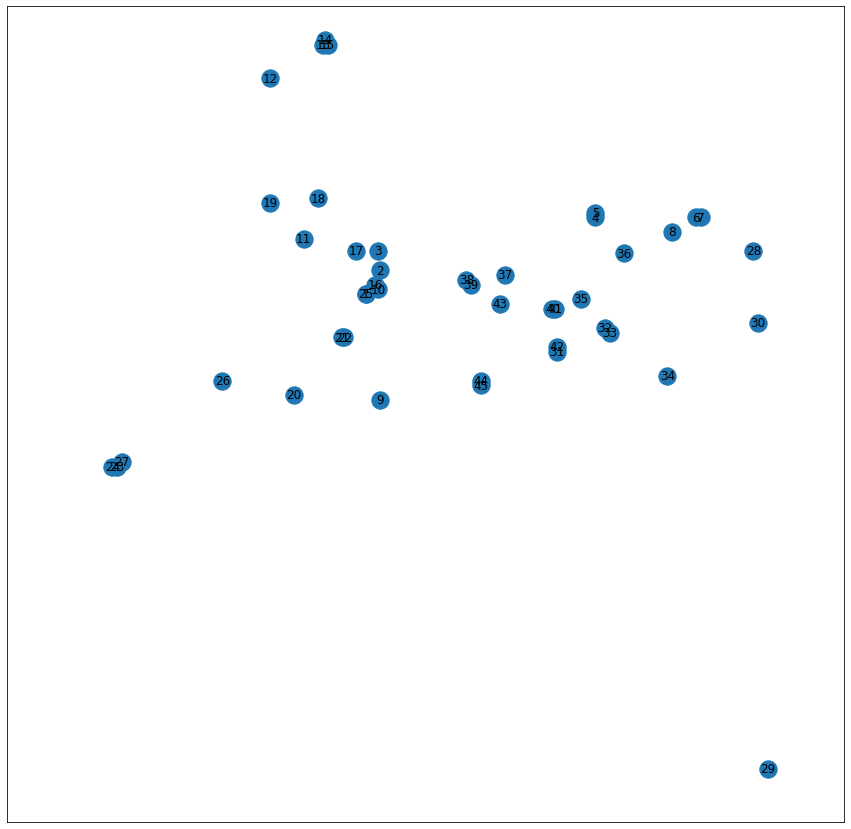

In [25]:
showNodes(manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

Testing the annealing process with the larger example. The steps are the same as the ones you had to comment in Question 4. Look at the additional step *plot_learning*, it shows the value of the fitness function as the annealing process occurs.  Run it multiple times, it is a probabilistic approach, so the result might be slightly different each time.

Solution ['32', '33', '35', '41', '40', '42', '31', '43', '37', '39', '38', '2', '16', '10', '25', '1', '17', '3', '11', '18', '19', '12', '13', '15', '14', '21', '22', '9', '20', '26', '27', '23', '24', '45', '44', '34', '30', '28', '7', '6', '8', '36', '4', '5', '29'] takes a total of 630.292


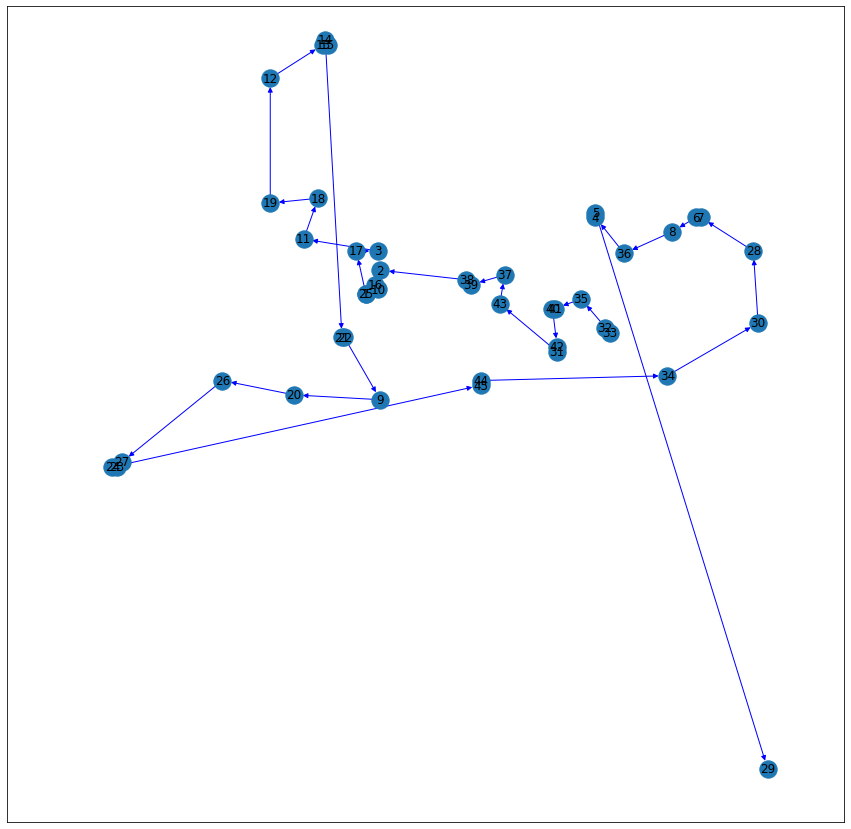

6.708203932499369
1e-08
Best fitness obtained:  513.089
Improvement over greedy heuristic:  0.0806


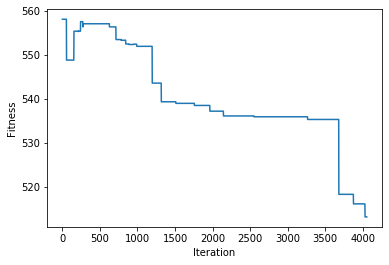

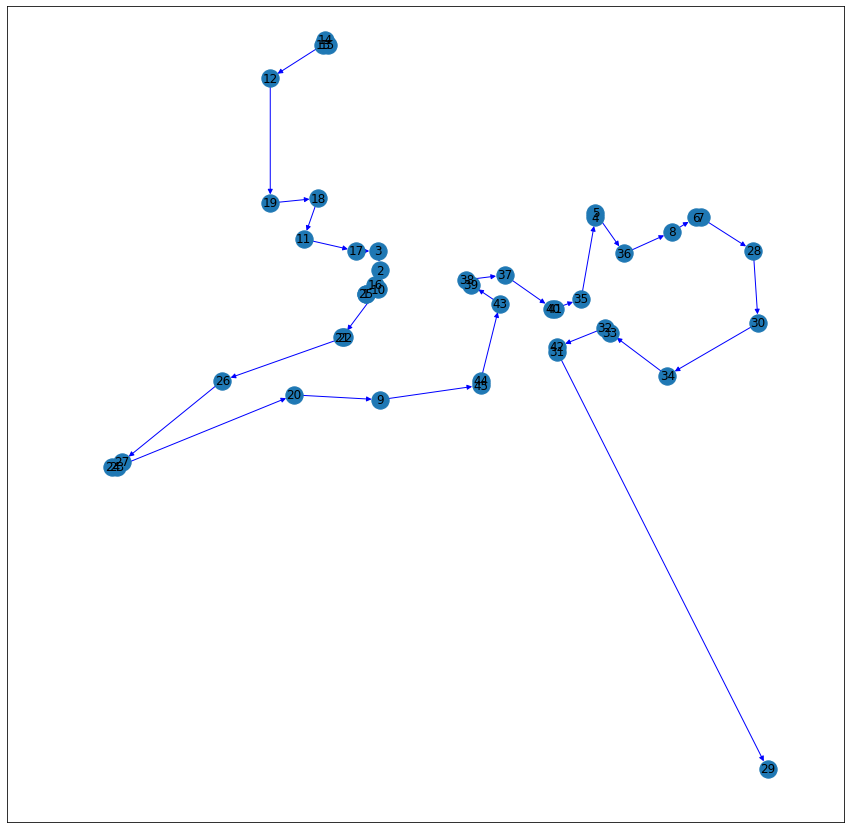

Closest node is:  ['37', '39', '38']
Closest node selected by distribution probability is:  37 , with a probability of:  0.4521427032053978
Closest node is:  ['39', '38', '40']
Closest node selected by distribution probability is:  39 , with a probability of:  0.4606002120335255
Closest node is:  ['38', '40', '41']
Closest node selected by distribution probability is:  38 , with a probability of:  0.9877483348202035
Closest node is:  ['2', '10', '40']
Closest node selected by distribution probability is:  10 , with a probability of:  0.3314078747850406
Closest node is:  ['16', '25', '1']
Closest node selected by distribution probability is:  16 , with a probability of:  0.7433767939183448
Closest node is:  ['25', '1', '2']
Closest node selected by distribution probability is:  2 , with a probability of:  0.2851823756590514
Closest node is:  ['3', '25', '1']
Closest node selected by distribution probability is:  3 , with a probability of:  0.5109120210142432
Closest node is:  ['17', '25

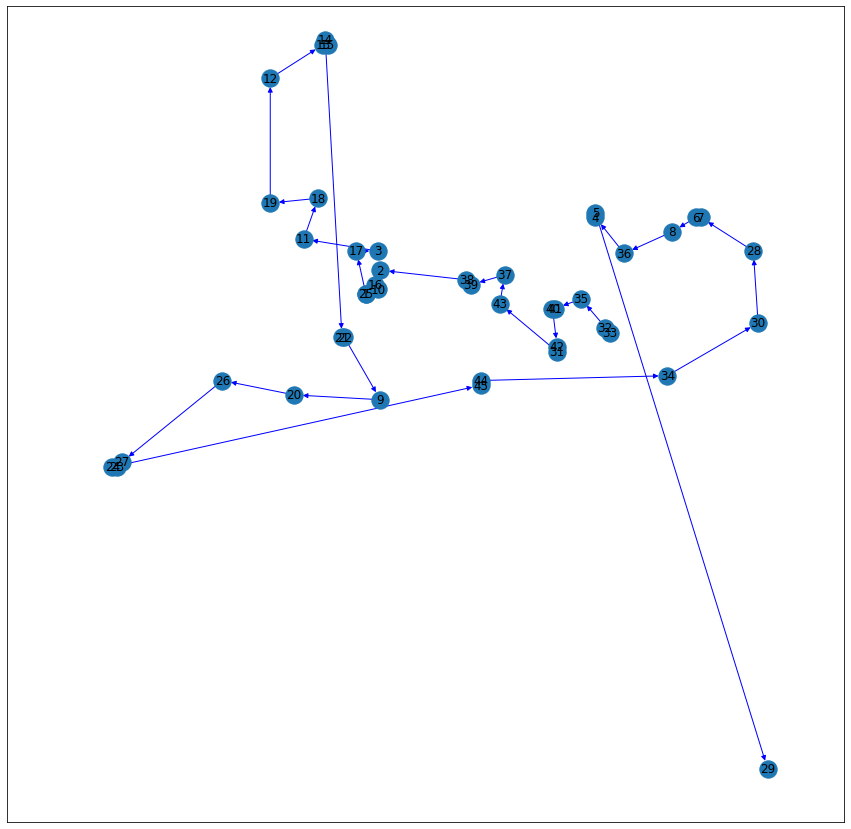

Closest node is:  ['33', '35', '42', '31']
Closest node selected by distribution probability is:  33 , with a probability of:  0.9380753503398748
Closest node is:  ['35', '42', '31', '41']
Closest node selected by distribution probability is:  35 , with a probability of:  0.35524754876451
Closest node is:  ['41', '40', '42', '31']
Closest node selected by distribution probability is:  41 , with a probability of:  0.4229091792606152
Closest node is:  ['40', '42', '31', '43']
Closest node selected by distribution probability is:  40 , with a probability of:  0.9912337142618939
Closest node is:  ['42', '31', '43', '37']
Closest node selected by distribution probability is:  43 , with a probability of:  0.19292232116714825
Closest node is:  ['37', '39', '38', '42']
Closest node selected by distribution probability is:  37 , with a probability of:  0.42084913537697544
Closest node is:  ['39', '38', '42', '31']
Closest node selected by distribution probability is:  38 , with a probability of

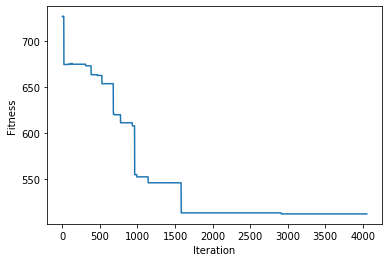

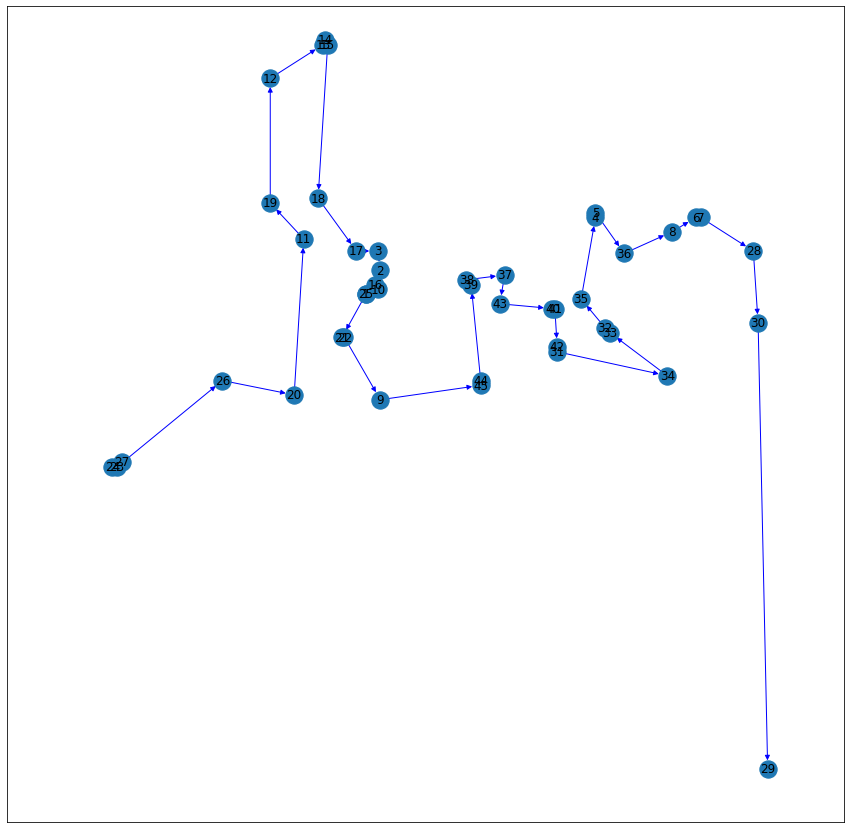

In [26]:
firstSol = greedy_solution(manyCities)
distances = distDict(manyCities)
print('Solution {} takes a total of {}'.format(firstSol,totalDist(firstSol, distances)))
showPath(firstSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

sa = SimAnneal(manyCities, False)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

secondSol = randomized_greedy_solution(manyCities, 3)
print('Solution {} takes a total of {}'.format(secondSol,totalDist(secondSol, distances)))
showPath(firstSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

sa2 = SimAnneal(manyCities, True, 4)
betterSol2 = sa2.anneal()
sa2.plot_learning()
showPath(betterSol2, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

**(TO DO) Q6 - 2 marks**   
Try the annealing again, but provide a different temperature schedule, by changing alpha, and the starting and stopping temperatures.  These are all parameters to the class which can be set.  Try also changing the number of iterations to do.  Explore 4 variations below.

6.708203932499369
1e-08
Best fitness obtained:  494.824
Improvement over greedy heuristic:  0.211


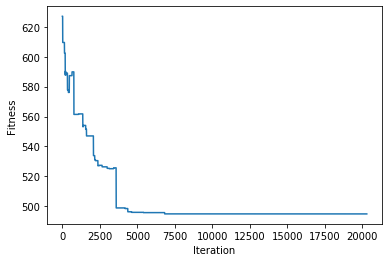

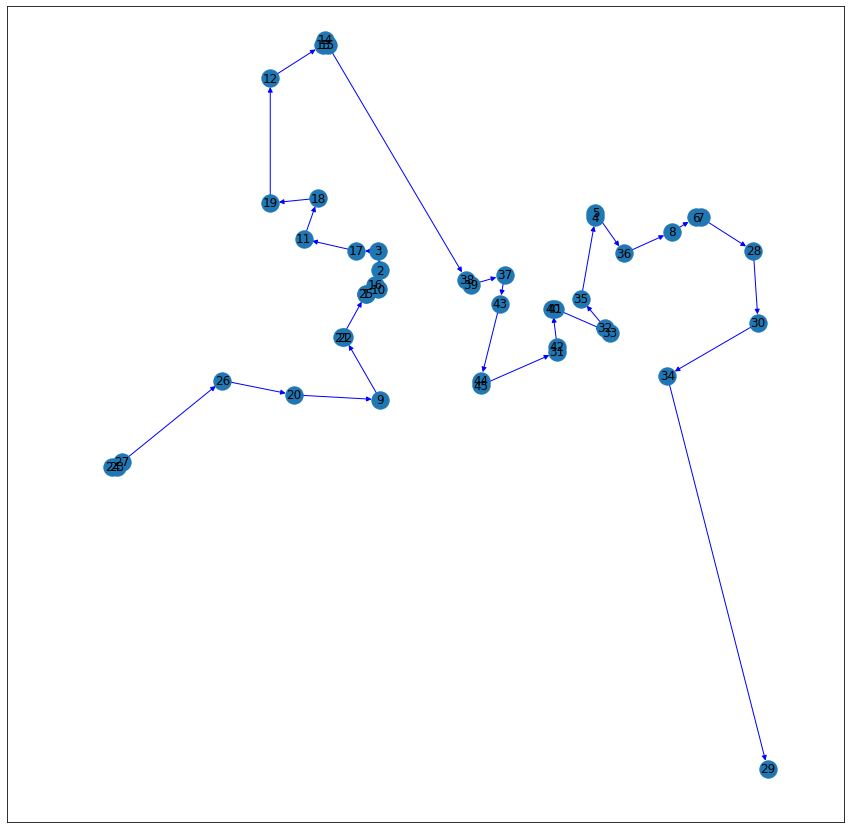

40
1e-08
Best fitness obtained:  498.467
Improvement over greedy heuristic:  0.1311


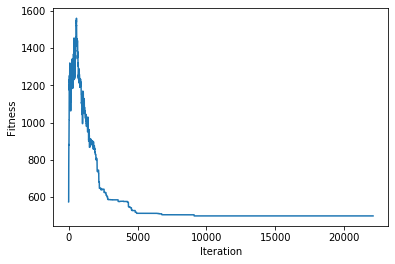

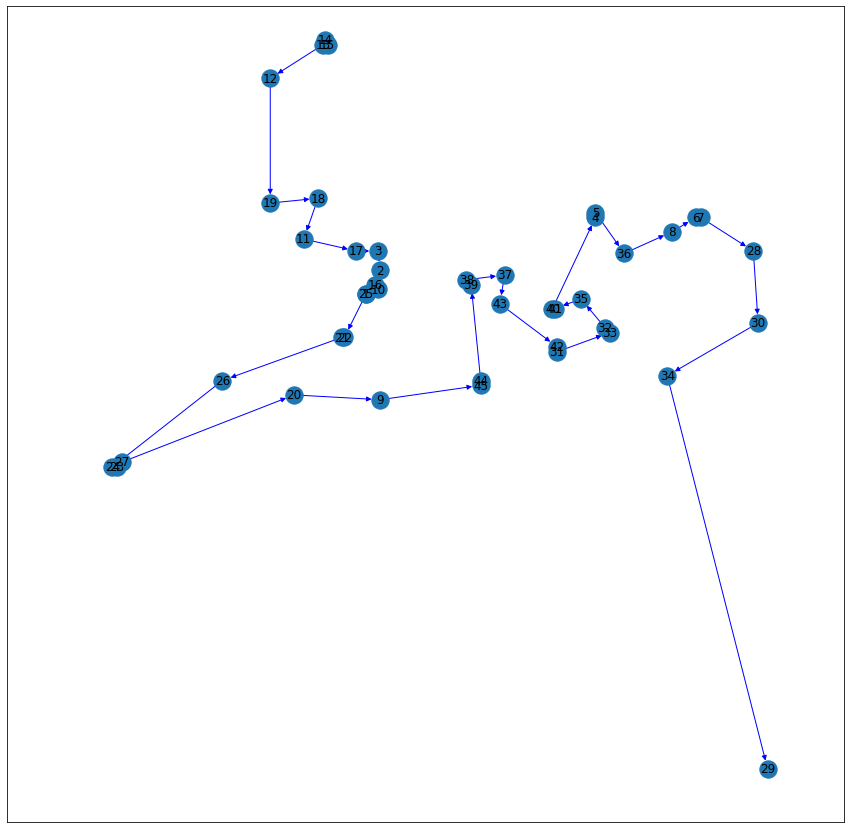

40
0.0005
Best fitness obtained:  496.907
Improvement over greedy heuristic:  0.1719


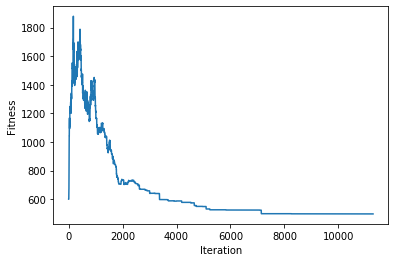

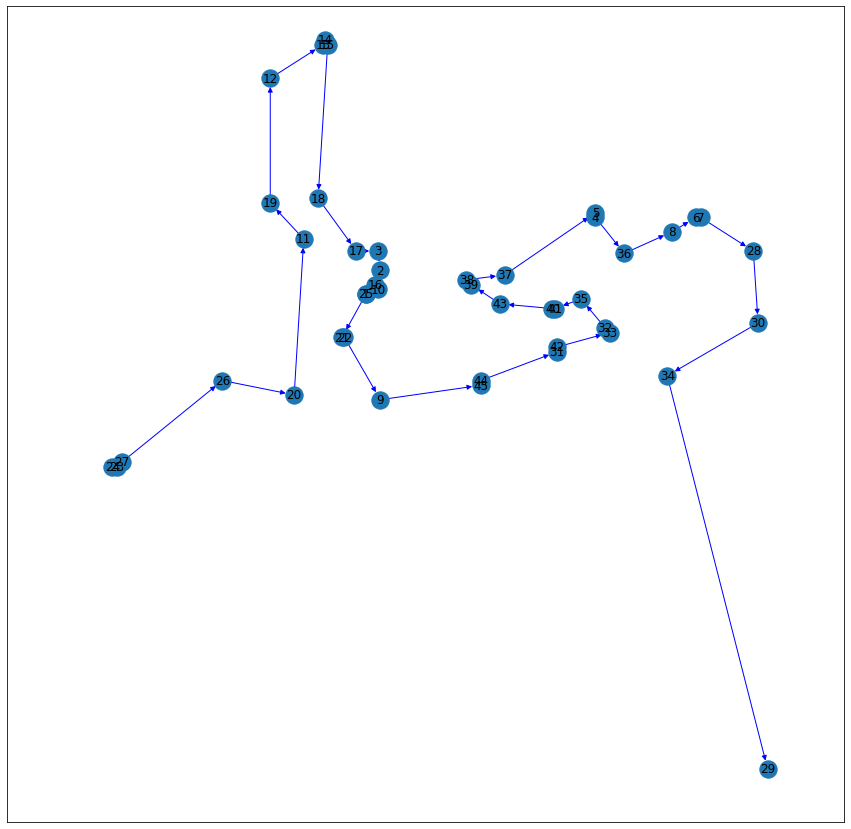

40
0.0005
Best fitness obtained:  505.39
Improvement over greedy heuristic:  0.1349


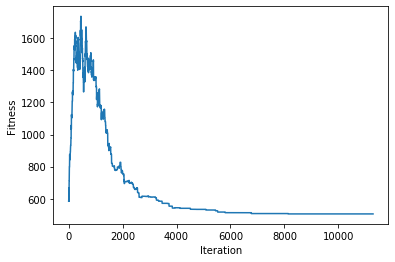

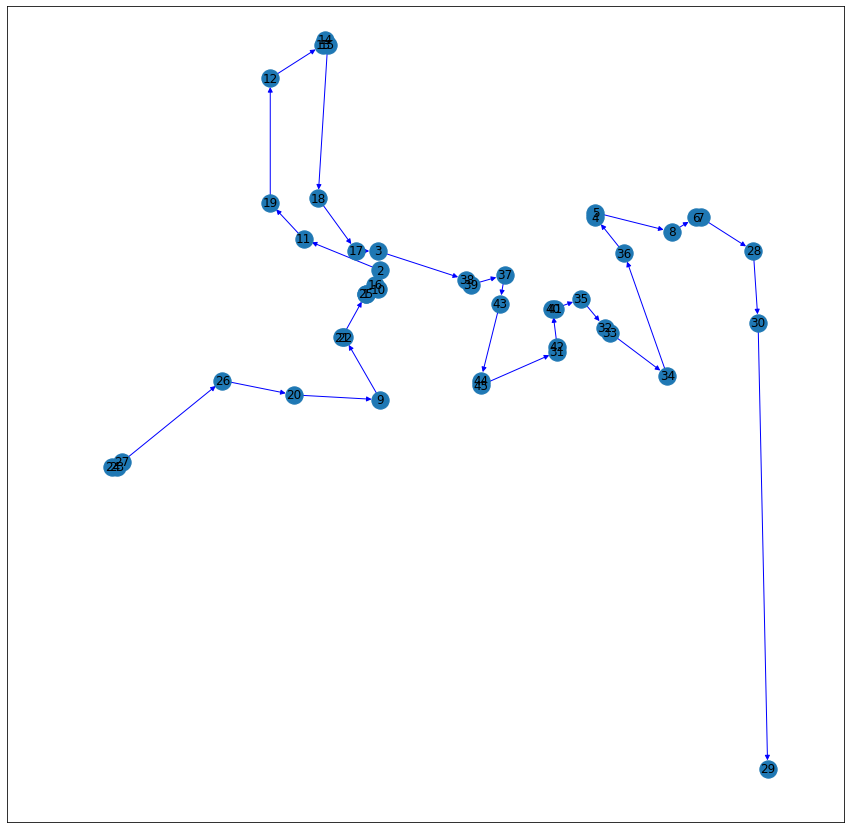

In [27]:
# (TO DO) Look at this line from the SimAnneal class above
# def __init__(self, nodes, randomizedGreedy, k=4, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
# This means that parameters k, T, alpha, stopping_T and stopping_iter all have defaults, but could be changed
# For example, calling SimAnneal(manyCities, False, stopping_iter=100) means that I set a maximum of 100 iterations for a 
# Greedy solution. Calling  SimAnneal(manyCities, True, k=3, stopping_iter=100) is the same for a randomized greedy solution
# with k = 3.
# Try four variations and look at the differences
# The key point of this question is to use different parameters to understand how they work
# What you need to do is create and run these four different examples

# Test 1 (Use a Greedy solution, see comment above) ...
sa = SimAnneal(manyCities, False, alpha = 0.999)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 2 (Use a Randomized Greedy solution, see comment above)...
sa = SimAnneal(manyCities, False, alpha=0.999, T=40)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 3 (Use a Greedy solution, see comment above)...
sa = SimAnneal(manyCities, False, alpha=0.999, T=40, stopping_T=0.0005,)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 4 (Use a Randomized Greedy solution, see comment above)...
sa = SimAnneal(manyCities, False, alpha=0.999, T=40, stopping_T=0.0005, stopping_iter=100000000000)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

#### Signature

I, Kenny Nguyen, declare that the answers provided in this notebook are my own.